# Ford GoBike System Data Exploration

## Preliminary Wrangling

The dataset selected was the [Ford GoBike System Data](https://www.fordgobike.com/system-data). The data is from Bay Wheels's trip data and is for public use and is provided according to the Bay Wheels License Agreement. The data is contained within a csv file titled `2017-fordgobike-tripdata.csv` and was downloaded in a zip with the same name. The data consists of rows that represent a bike trip. Each trip is anonymized and includes:

- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type(Subscriber or Customer - "Subscriber" = Member or "Customer" = Casual)

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# read in the data from the csv `2017-fordgobike-tripdata.csv` from the data folder
fordgobike_tripdata = pd.read_csv('data/2017-fordgobike-tripdata.csv', parse_dates = ['start_time', 'end_time'])

In [3]:
df = fordgobike_tripdata.copy() # make a copy of original df
df.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer


In [4]:
# Made `user_type` a category
df['user_type'] = df['user_type'].astype('category')
# Transformed `start_time` to `day_of_week`
df['start_day'] = df.start_time.dt.day_name()
# Made `start_day` a category
day_of_wk = ['Sunday','Monday','Tuesday','Wednesday','Thursday', 'Friday','Saturday']
cat_type = pd.api.types.CategoricalDtype(ordered=True, categories=day_of_wk)
df['start_day'] = df['start_day'].astype(cat_type)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             519700 non-null  int64         
 1   start_time               519700 non-null  datetime64[ns]
 2   end_time                 519700 non-null  datetime64[ns]
 3   start_station_id         519700 non-null  int64         
 4   start_station_name       519700 non-null  object        
 5   start_station_latitude   519700 non-null  float64       
 6   start_station_longitude  519700 non-null  float64       
 7   end_station_id           519700 non-null  int64         
 8   end_station_name         519700 non-null  object        
 9   end_station_latitude     519700 non-null  float64       
 10  end_station_longitude    519700 non-null  float64       
 11  bike_id                  519700 non-null  int64         
 12  user_type       

In [6]:
df.shape

(519700, 14)

### What is the structure of your dataset?
The structure of the dataset consists of 519700 rows and 13 columns which are displayed above. Each row in the dataset represents a trip that can be conducted between two user types 'Customer' or 'Subscriber'. The rest of the columns describe the start and end times of those trips as well as the station names and latitude & longitudes. 

### What is/are the main feature(s) of interest in your dataset?

Main features of interest for this exploration are:
- user_type
- duration_sec

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
- bike_id
- start_station_id
- end_station_id
- start_day

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

**Variable user_type**

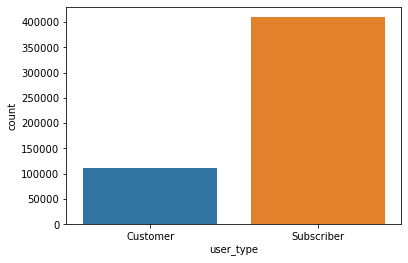

In [7]:
# user_type
sb.countplot(data = df, x = 'user_type');

In [8]:
df.user_type.value_counts()

Subscriber    409230
Customer      110470
Name: user_type, dtype: int64

In [9]:
df.user_type.value_counts()[1] / df.user_type.value_counts()[0]

3.704444645605142

It appears that their are way more members or subscribers taking trips than the casual customer. Almost four times the amount more.

**Variable duration_sec**

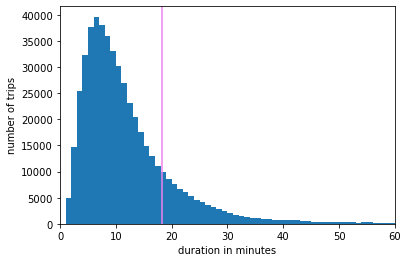

In [10]:
# transformed the duration.sec into minutes
df['duration_min'] = df.duration_sec / 60
# created bins
bins = np.arange(0, df['duration_min'].max()+2, 1)
plt.hist(data = df, x = 'duration_min', bins = bins)
plt.xlim((0, 60)) # limit the view
plt.axvline(x=df['duration_min'].mean(), color='violet') # mean `duration_min`
plt.xlabel('duration in minutes')
plt.ylabel('number of trips');

`duration_sec` which I transformed to `duration_min` seems skewed to the right with the averaging being a less than a 20min bike ride

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

I did have to transform `duration_sec` to `duration_min` by dividing by 60 to get the minutes. I then had to filter down even further in the graphs due to outliers in the set. There is also way more members than casual customers then I thought there would be.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

As mentioned I did transform the duration in seconds to duration in minutes close the gap on the min and max values and condense the dataset. This way it was a bit easier to graph, read, and understand.

## Bivariate Exploration

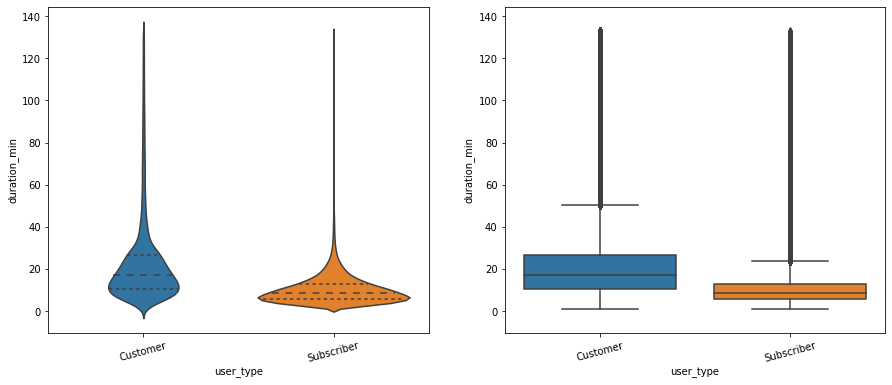

In [11]:
# based on the above univariate exploration we should try to filter out outliers from `duration_min` to make better
# better sense of the data when comparing it to other variables

theshold = df.duration_min.mean() + (df.duration_min.std()*2) # creating a limit of 2 std from the mean
outliers = df[df.duration_min > theshold] # outlier rows here
cl_df = df[df.duration_min < theshold] # clean dataset less outliers

plt.figure(figsize = [15,6])

# left plot
plt.subplot(1,2,1)
ax1 = sb.violinplot(data=cl_df, x='user_type', y='duration_min', inner='quartile')
plt.xticks(rotation = 15)

# right plot
plt.subplot(1,2,2)
sb.boxplot(data=cl_df, x='user_type', y='duration_min')
plt.xticks(rotation = 15)
plt.ylim(ax1.get_ylim()); # set y axis to be same for both plots

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

It appears that Subscribers generate more trips but of shorter lengths compared to Customer who seem to take less trips overall but they tend to take longer trips.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

I do not have time to do this but if I was interested in analyzing usage I code recode the `start_time` and `end_time` columns to days and hours of the day to see if there is usage relationships between `user_type` and `duration..`. I could incorporate those features ID variables (start_station_id, end_station_id, bike_id, name, etc) into a bivariate analysis but I would much rather use them for the multivariate exploration part coming up. 

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

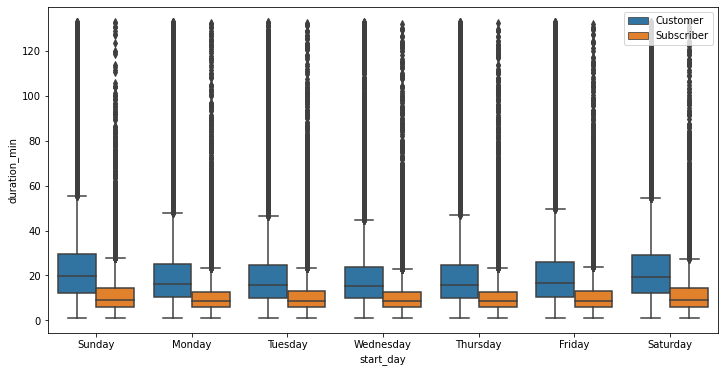

In [24]:
# Increase plot size
plt.figure(figsize = [12,6])
# create boxplot of duration_min across start_day segemented by user_type
sb.boxplot(data = cl_df, x='start_day', y='duration_min', hue='user_type',);
plt.legend(loc='upper right'); # replace legend

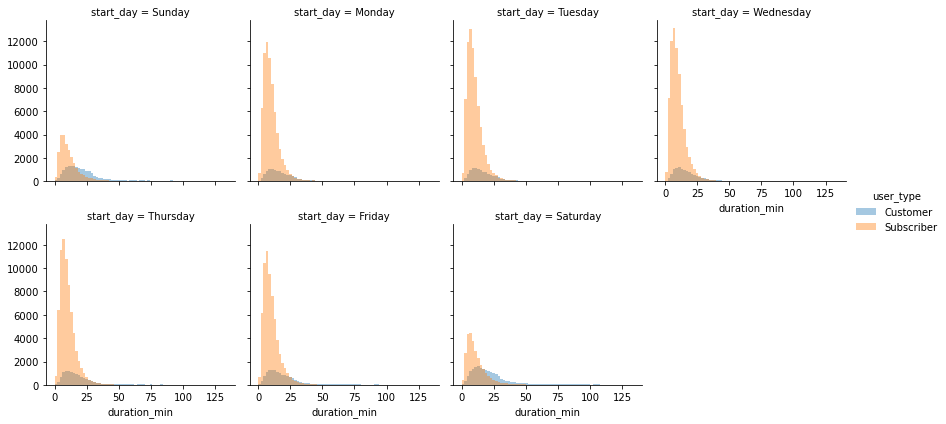

In [43]:
g = sb.FacetGrid(data=cl_df, col='start_day', col_wrap=4, hue='user_type', margin_titles=True)
bins = np.arange(0, cl_df['duration_min'].max()+2, 2)
g = g.map(plt.hist,'duration_min', alpha=.4, bins = bins)
g.add_legend();

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

There seems to be a relationship between day of the week and usage as well as the trend of the usage through the week in relationship to user type. Additionally certain user groups ebb and flow differently depending on if its a weekend vs week day.

### Were there any interesting or surprising interactions between features?

Yes, it appears that the casual customer is the more stable user and has less variability in usage then the member/subscriber user which I would not expect. In fact, I would assume the opposite. The subscriber user is also making up the bulk of the trips through out the week with those mostly being smaller, shorter trips.